# Modelling

In [1]:
import numpy as np

data = np.load("colposcopy_lstm_data.npz")

X_train_lstm = data["X_train_lstm"]
y_train      = data["y_train"]        
y_train_enc  = data["y_train_enc"]
X_test_lstm  = data["X_test_lstm"]
y_test       = data["y_test"]
y_test_enc   = data["y_test_enc"]

print("y_train shape:", y_train.shape)
print("unique labels:", np.unique(y_train))

y_train shape: (99,)
unique labels: ['0' '1' '2' '3' '4' '5']


## Balancing Data

In [2]:
from sklearn.utils.class_weight import compute_class_weight

y_train = y_train.astype(int)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(6),   
    y=y_train
)

class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print("Class Weights:")
for k, v in class_weight_dict.items():
    print(f"Class {k} : {v:.4f}")

Class Weights:
Class 0 : 2.3571
Class 1 : 1.3750
Class 2 : 1.6500
Class 3 : 0.6875
Class 4 : 0.9167
Class 5 : 0.5893


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(
        units=64,
        input_shape=(180, 1),
        return_sequences=False
    ),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(6, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 19,174
Trainable params: 19,174
Non-trainable params: 0
_________________________________________________________________


## Trainning

In [4]:
history = model.fit(
    X_train_lstm,
    y_train_enc,
    epochs=50,
    batch_size=16,
    validation_split=0.2,  
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/50
5/5 [==============================] - 3s 197ms/step - loss: 1.9707 - accuracy: 0.1772 - val_loss: 1.8788 - val_accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 72ms/step - loss: 1.9530 - accuracy: 0.3038 - val_loss: 1.9690 - val_accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 78ms/step - loss: 1.9563 - accuracy: 0.2911 - val_loss: 2.0712 - val_accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 66ms/step - loss: 1.9575 - accuracy: 0.1772 - val_loss: 2.1122 - val_accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 57ms/step - loss: 1.9513 - accuracy: 0.2278 - val_loss: 2.1787 - val_accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 64ms/step - loss: 1.9273 - accuracy: 0.1519 - val_loss: 2.2564 - val_accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 61ms/step - loss: 1.9355 - accuracy: 0.1392 - val_loss: 2.3482 - val_accuracy: 0.0000e+0

In [8]:
model.save("colposcopy_lstm_model.h5")

In [5]:
y_pred_prob = model.predict(X_test_lstm)

y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_test_enc, axis=1)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

4/4 [==============================] - 1s 29ms/step
y_true shape: (101,)
y_pred shape: (101,)


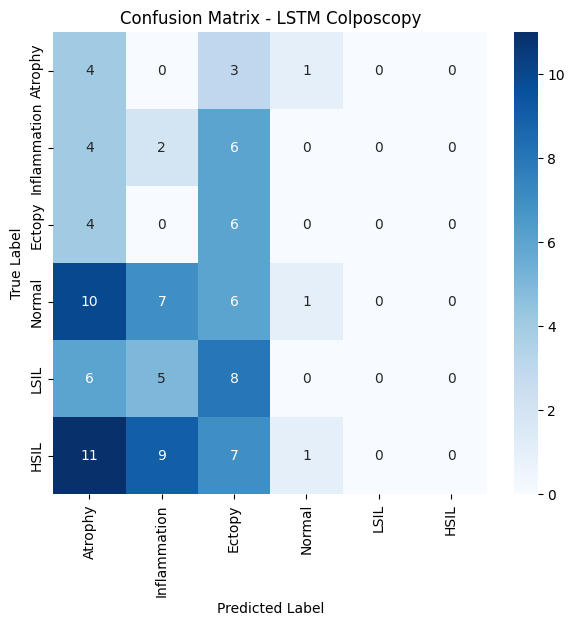

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["Atrophy","Inflammation","Ectopy","Normal","LSIL","HSIL"],
    yticklabels=["Atrophy","Inflammation","Ectopy","Normal","LSIL","HSIL"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM Colposcopy")
plt.show()

In [7]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=[
        "Atrophy", "Inflammation", "Ectopy",
        "Normal", "LSIL", "HSIL"
    ]
))


              precision    recall  f1-score   support

     Atrophy       0.10      0.50      0.17         8
Inflammation       0.09      0.17      0.11        12
      Ectopy       0.17      0.60      0.26        10
      Normal       0.33      0.04      0.07        24
        LSIL       0.00      0.00      0.00        19
        HSIL       0.00      0.00      0.00        28

    accuracy                           0.13       101
   macro avg       0.11      0.22      0.10       101
weighted avg       0.11      0.13      0.07       101



c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif